In [1]:
using Random, SCS, PyPlot, JuMP, Printf, LinearAlgebra

### Question 1

In [2]:
function random_instance(k,m,n)
    
    S1 = randperm(n)[1:k]
    S2 = randperm(n)[1:k]
    
    u = zeros(n,1)
    u[S1] = randn(k,1)
    v = zeros(n,1)
    v[S2] = randn(k,1)

    X = u * v'

    As = [randn(n,n) for _ in range(1,m)]
    ys = [sum(X .* A) for A in As]
    
    return X, S1, S2, As, ys
end

random_instance (generic function with 1 method)

### Question 2
The problem to solve is
\begin{align*}
\mbox{Find }&Z \\
\mbox{such that }&\mathrm{rank}(Z) = 1, \\
& Z \in \bigcup_{|S_1|,|S_2|\leq k} \{Z'\in\mathbb{R}^{n\times n}\mbox{ s.t. }Z'_{s,s'} = 0,\forall (s,s')\notin S_1\times S_2\}, \\
& \langle A_i,Z\rangle = y_i, \forall i\leq m.
\end{align*}
The set $\{Z\in\mathbb{R}^{n\times n},\mathrm{rank}(Z)=1\}$ is non-convex if $n>1$ (as seen in class). The set $\bigcup_{|S_1|,|S_2|\leq k} \{Z'\in\mathbb{R}^{n\times n}\mbox{ s.t. }Z'_{s,s'} = 0,\forall (s,s')\notin S_1\times S_2\}$ is also not convex : the average of two $Z'$ in this set is not in the set if the corresponding $S_1$ or $S_2$ are different. The problem is therefore non-convex.

### Question 3
a) The nuclear norm $F_1:Z\in\mathbb{R}^{n\times n} \to ||Z||_*$.

b) The second information is a sparsity constraint, so we could use the $\ell^1$-norm $F_2:Z\in\mathbb{R}^{n\times n} \to \sum_{1\leq i,j\leq n} |Z_{i,j}|$.

c)

In [3]:
function convex_method(lambda,As,ys ; F1orF2="both")

    n = size(As[1])[1]
    m = length(As)

    # Solve the problem
    pb = Model(SCS.Optimizer)
    set_attribute(pb, "verbose", false)
    
    @variable(pb,Z[1:n,1:n])
    @constraint(pb, [k=1:m], tr(Z * As[k]') == ys[k])
    if (F1orF2 == "both")
        @variable(pb,l1_norm)
        @constraint(pb, [l1_norm; vec(Z)] in MOI.NormOneCone(n^2+1))
        @variable(pb,nuc_norm)
        @constraint(pb, [nuc_norm; vec(Z)] in MOI.NormNuclearCone(n,n))
        @objective(pb,Min,nuc_norm + lambda*l1_norm)
    elseif (F1orF2 == "F1")
        @variable(pb,nuc_norm)
        @constraint(pb, [nuc_norm; vec(Z)] in MOI.NormNuclearCone(n,n))
        @objective(pb,Min,nuc_norm)
    elseif (F1orF2 == "F2")
        @variable(pb,l1_norm)
        @constraint(pb, [l1_norm; vec(Z)] in MOI.NormOneCone(n^2+1))
        @objective(pb,Min,l1_norm)
    else
        throw(ArgumentError("Invalid value for F1orF2"))
    end
    optimize!(pb)
    
    return value.(Z)
end

convex_method (generic function with 1 method)

d)

In [4]:
function support_recovery_error(X,S1,S2,Z)
    minX = minimum(abs.(X[S1,S2]))
    n = size(X)[1]
    err = 0
    for k=1:n
        for l=1:n
            if ((k ∉ S1) || (l ∉ S2)) && (abs(Z[k,l]) > minX / 10)
                err += 1
            elseif (k in S1) && (l in S2) && (abs(Z[k,l]) < minX / 10)
                err += 1
            end
        end
    end
    return err
end

support_recovery_error (generic function with 1 method)

e) If $m \geq n^2=16$, then the linear measurements alone determine $X$ with probability $1$. Therefore, support recovery error should always be zero. For $m$ slightly below $16$ ($m=14$ in the following code), the error also seems to be zero most of the time.

In [5]:
X, S1, S2, As, ys = random_instance(2,16,4) ;
Z = convex_method(1,As,ys;F1orF2="F2")
@printf("Support recovery error for m=16: %d\n",support_recovery_error(X,S1,S2,Z))
X, S1, S2, As, ys = random_instance(2,14,4) ;
Z = convex_method(1,As,ys)
@printf("Support recovery error for m=14: %d\n",support_recovery_error(X,S1,S2,Z))

Support recovery error for m=16: 0
Support recovery error for m=14: 0


f) Comments on the graphs below:
* The Frobenius norm error follows closely the support recovery error. In particular, when the support recovery error is zero, the Frobenius norm error is also zero (which is expected: since $m=20 \geq 9 = k^2$, the linear measurements allow to exactly recover the ground true matrix if the support is known).
* Most of the time, the support recovery error is zero for either small values of $\lambda$ or large values of $\lambda$.
* Since very small values of $\lambda$ correspond to ignoring $F_2$ while very large values correspond to ignoring $F_1$, it seems that using a linear combination of $F_1$ and $F_2$ is not more efficient than using either $F_1$ or $F_2$. The algorithm exploits either low-rankness or sparsity, but not both at the same time.

In [6]:
X, S1, S2, As, ys = random_instance(3,20,6) ;
lambdas = 10. .^ (collect(range(-4,4))./2)
supp_err = zeros(length(lambdas))
frob_err = zeros(length(lambdas))
for kit=1:length(lambdas)
    Z = convex_method(lambdas[kit],As,ys)
    supp_err[kit] = support_recovery_error(X,S1,S2,Z)
    frob_err[kit] = norm(Z-X)
end

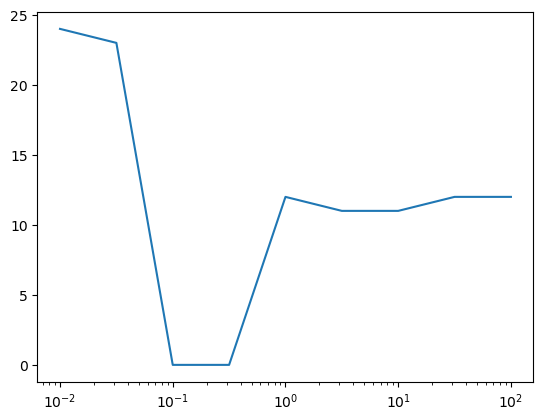

In [7]:
PyPlot.plot(lambdas,supp_err)
PyPlot.xscale("log")

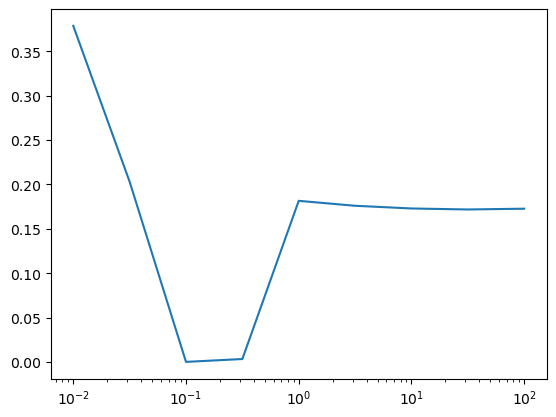

In [8]:
PyPlot.plot(lambdas,frob_err)
PyPlot.xscale("log")

g)

In [9]:
function rec_with_proba_half(n,ks ; F1orF2="both")
    
    ms = zeros(length(ks))
    lambdas = [10. ^ k for k in range(-2,2)]

    for kind = 1:length(ks)

        k = ks[kind]
        println("k = ",k)
        nb_tests = 20
    
        # Dichotomy search for the smallest m at which empirical recovery error is above 50%
        m1 = k-1
        prob1 = 0 # k-1 measurements do not allow recovery
        if (F1orF2 == "F1") || (F1orF2 == "both")
            m2 = 10*n
            prob2 = 1 # Convex relaxation solves rank 1 matrix recovery from O(n)
                      # normally distributed measurements, even without the sparsity constraint.
        elseif (F1orF2 == "F2")
            m2 = min(round(Int64,10*k^2*log(n/k)),n^2) # Basis pursuit succeeds
                                                       # with high proba above this
                                                       # threshold.
            prob2 = 1
        end

        while (m2 > m1 + 3) # Precision of 3 units is reasonable
            m = round(Int64,(m1+m2)/2)
            prob = 0
            for _ = 1:nb_tests
                # Select a random instance
                X, S1, S2, As, ys = random_instance(k,m,n) ;

                # See whether the algorithm reconstructs X
                if (F1orF2 == "both")
                    # Convex approximation: combination of the two norms
                    exact_reco = false
                    for kit=1:length(lambdas)
                        Z = convex_method(lambdas[kit],As,ys)
                        if (support_recovery_error(X,S1,S2,Z) == 0)
                            exact_reco = true
                            break
                        end
                    end
                elseif (F1orF2 == "F1") || (F1orF2 == "F2")
                    # Convex approximation: one of the norms only
                    Z = convex_method(0,As,ys ; F1orF2=F1orF2)
                    exact_reco = (support_recovery_error(X,S1,S2,Z) == 0)
                else
                    throw(ArgumentError("Invalid value for F1orF2"))
                end
                
                if exact_reco
                    prob += 1/nb_tests
                end
            end

            # Update the dichotomy limits
            if (prob > 0.5)
                m2 = m
                prob2 = prob
            else
                m1 = m
                prob1 = prob
            end
            @printf("proba %.2f for m1=%d ; proba %.2f for m2=%d\n",prob1,m1,prob2,m2)
            flush(stdout)
        end

        println("m = ",round(Int64,(m1+m2)/2))
        ms[kind] = round(Int64,(m1+m2)/2)
    end

    return ms
end

rec_with_proba_half (generic function with 1 method)

In [10]:
n = 30
ks = collect(1:2:15)
ms_both = rec_with_proba_half(n,ks ; F1orF2="both") ;

k = 1
proba 0.00 for m1=0 ; proba 1.00 for m2=150
proba 0.00 for m1=0 ; proba 1.00 for m2=75
proba 0.00 for m1=0 ; proba 1.00 for m2=38
proba 0.00 for m1=0 ; proba 0.95 for m2=19
proba 0.00 for m1=0 ; proba 0.55 for m2=10
proba 0.10 for m1=5 ; proba 0.55 for m2=10
proba 0.10 for m1=5 ; proba 0.60 for m2=8
m = 6
k = 3
proba 0.00 for m1=2 ; proba 1.00 for m2=151
proba 0.00 for m1=2 ; proba 1.00 for m2=76
proba 0.40 for m1=39 ; proba 1.00 for m2=76
proba 0.40 for m1=39 ; proba 0.95 for m2=58
proba 0.40 for m1=39 ; proba 0.90 for m2=48
proba 0.45 for m1=44 ; proba 0.90 for m2=48
proba 0.45 for m1=44 ; proba 0.70 for m2=46
m = 45
k = 5
proba 0.00 for m1=4 ; proba 0.95 for m2=152
proba 0.20 for m1=78 ; proba 0.95 for m2=152
proba 0.20 for m1=78 ; proba 0.95 for m2=115
proba 0.20 for m1=78 ; proba 0.90 for m2=96
proba 0.20 for m1=78 ; proba 0.85 for m2=87
proba 0.20 for m1=78 ; proba 0.60 for m2=82
proba 0.40 for m1=80 ; proba 0.60 for m2=82
m = 81
k = 7
proba 0.00 for m1=6 ; proba 0.90 for m

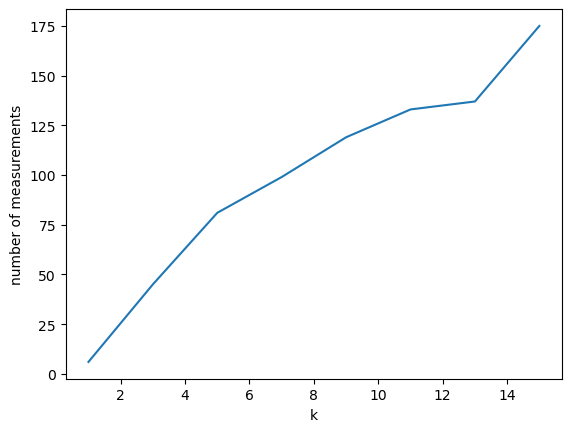

In [11]:
PyPlot.plot(ks,ms_both)
PyPlot.xlabel("k")
PyPlot.ylabel("number of measurements") ;

h)

In [12]:
ms_F1 = rec_with_proba_half(n,ks ; F1orF2="F1") ;
ms_F2 = rec_with_proba_half(n,ks ; F1orF2="F2") ;

k = 1
proba 0.00 for m1=0 ; proba 1.00 for m2=150
proba 0.00 for m1=0 ; proba 0.70 for m2=75
proba 0.50 for m1=38 ; proba 0.70 for m2=75
proba 0.50 for m1=38 ; proba 0.60 for m2=56
proba 0.50 for m1=38 ; proba 0.65 for m2=47
proba 0.50 for m1=38 ; proba 0.55 for m2=42
proba 0.50 for m1=40 ; proba 0.55 for m2=42
m = 41
k = 3
proba 0.00 for m1=2 ; proba 0.75 for m2=151
proba 0.00 for m1=76 ; proba 0.75 for m2=151
proba 0.05 for m1=114 ; proba 0.75 for m2=151
proba 0.40 for m1=132 ; proba 0.75 for m2=151
proba 0.50 for m1=142 ; proba 0.75 for m2=151
proba 0.50 for m1=142 ; proba 0.70 for m2=146
proba 0.50 for m1=142 ; proba 0.60 for m2=144
m = 143
k = 5
proba 0.00 for m1=4 ; proba 0.60 for m2=152
proba 0.00 for m1=78 ; proba 0.60 for m2=152
proba 0.05 for m1=115 ; proba 0.60 for m2=152
proba 0.35 for m1=134 ; proba 0.60 for m2=152
proba 0.25 for m1=143 ; proba 0.60 for m2=152
proba 0.35 for m1=148 ; proba 0.60 for m2=152
proba 0.50 for m1=150 ; proba 0.60 for m2=152
m = 151
k = 7
proba 0.

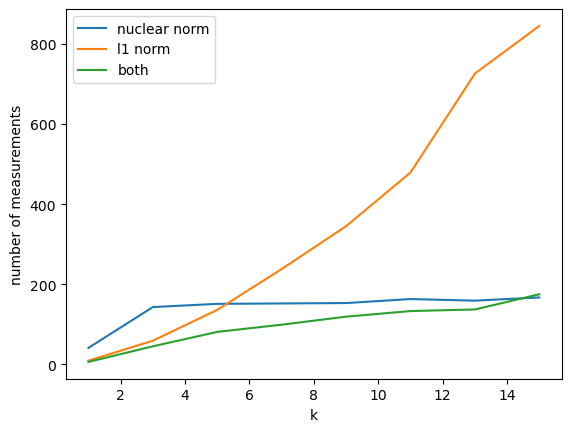

PyObject <matplotlib.legend.Legend object at 0x7f0edc3b9fd0>

In [13]:
PyPlot.plot(ks,ms_F1,label="nuclear norm")
PyPlot.plot(ks,ms_F2,label="l1 norm")
PyPlot.plot(ks,ms_both,label="both")
PyPlot.xlabel("k")
PyPlot.ylabel("number of measurements")
PyPlot.legend()

i) Comments on the graphs from Questions f) and g):
* The number of measurements necessary for recovery is an increasing function of $k$ (although the curves may not be perfectly monotonic, due to errors in the empirical computation of the probability recovery.
* Following the results seen in class, we expect $\ell^1$-norm recovery to succeed when the number of measurements is $O(k^2)$, up to log factors; the orange curve indeed seems to grow quadratically.
* The nuclear norm only exploits the fact that the unknown matrix has rank $1$, not its sparsity. Therefore, its performance should not be highly sensitive to the value of $k$. Indeed, the blue curve seems roughly constant, especially for $k\geq 5$.
* Combining the $\ell^1$ and nuclear norms allows for a strict, but moderate improvement compared to using one of the norms only. The largest improvement seems to be when $k=6$; recovery is possible (with probability $1/2$) with $m\approx 90$ for the combination of norms, while $m\approx 190$ is necessary when only one of the norms is used.

4.a) For any $k,l$,
\begin{align*}
\mathbb{E}(Z_{k,l})
& = \frac{1}{m} \sum_{i=1}^m \mathbb{E}\left(\left\langle A_i,X\right\rangle (A_i)_{k,l}\right) \\
& = \frac{1}{m} \sum_{i=1}^m \mathbb{E}\left(\sum_{k',l'=1}^n (A_i)_{k',l'}X_{k',l'} (A_i)_{k,l}\right) \\
& = \frac{1}{m} \sum_{i=1}^m \sum_{k',l'=1}^n X_{k',l'} \mathbb{E}\left((A_i)_{k',l'} (A_i)_{k,l}\right) \\
& = X_{k,l}.
\end{align*}

b) If the number of measurements is large enough, we expect $Z\approx X$, hence the largest entries of $Z$ (in absolute value) should be roughly at the same position as the largest entries of $X$. This suggests, for instance, to compute $Z$ and estimate $S_1$ as the indices of the rows with largest norm, and $S_2$ as the indices of the columns with largest norm.

[Note: other strategies are possible; you may choose a different one.]

In [14]:
function approx_support(Z,k)

    sum_rows = vec(sum(Z.^2,dims=2))
    sum_col = vec(sum(Z.^2,dims=1))
    S1 = sortperm(sum_rows,rev=true)[1:k]
    S2 = sortperm(sum_col,rev=true)[1:k]

    return S1, S2
    
end

approx_support (generic function with 1 method)

c) A simple strategy, if $S_1,S_2$ are known, is to try to minimize the following objective:
\begin{equation*}
    \begin{array}{rcccc}
        F&:&\mathbb{R}^{S_1\times S_2}&\to&\mathbb{R} \\
        &&(u,v)&\to& \frac{1}{2}\sum_{i=1}^m \left(y_i - \langle (A_i)_{S_1,S_2} , uv^T \rangle \right)^2.
    \end{array}
\end{equation*}
Here, "$(A_i)_{S_1,S_2}$" denotes the restriction of $A_i$ to coefficients $(s_1,s_2)$ for $s_1\in S_1,s_2\in S_2$. In the following code, we minimize this objective using gradient descent, starting at a random initial point.

In [15]:
function approx_X_from_support(S1,S2,As,ys;print_info=false,nb_its=1000)

    m = length(ys)
    n = size(As[1])[1]
    k = length(S1)
    
    As_sub = [A[S1,S2] for A in As]
    function obj(u,v)
        return 0.5 * sum([sum(As_sub[l] .* (u*v'))-ys[l] for l=1:m].^2)
    end
    function grad_obj(u,v)
        grad_u = sum([(sum(As_sub[l] .* (u*v'))-ys[l]) * (As_sub[l]*v) for l=1:m])
        grad_v = sum([(sum(As_sub[l] .* (u*v'))-ys[l]) * (As_sub[l]'*u) for l=1:m])
        return grad_u, grad_v
    end

    u = randn((k,1))
    v = randn((k,1))

    for kit=1:nb_its
        grad_u, grad_v = grad_obj(u,v)

        # Stopping criterion
        norm_grad = sqrt(norm(grad_u)^2 + norm(grad_v)^2)
        if (norm_grad < 1e-6)
            break
        end
        
        if (kit==1)
            # Step initialization
            global step = 0.1 * sqrt(norm(u)^2 + norm(v)^2) / norm_grad
        end

        utest = u - step * grad_u
        vtest = v - step * grad_v
        # Backtracking linesearch
        while obj(utest,vtest) > obj(u,v) - step * norm_grad^2 / 2
            step /= 2
            utest = u - step * grad_u
            vtest = v - step * grad_v
        end
        u = utest
        v = vtest
        step *= 1.1
    end

    if print_info
        @printf("Final objective: %.2f\n",obj(u,v))
        grad_u, grad_v = grad_obj(u,v)
        norm_grad = sqrt(norm(grad_u)^2 + norm(grad_v)^2)
        @printf("Final gradient norm: %.2e\n", norm_grad)
    end
    Xrec = zeros(n,n)
    Xrec[S1,S2] = u * v'
    
    return Xrec
    
end

approx_X_from_support (generic function with 1 method)

d) Results are displayed below. At least for these values of $k$ and $n$, the algorithm does not work well, except when $m$ is really large (well above $100$). A redhibitory issue is that the supports $S_1,S_2$ are not correctly estimated. The entries corresponding to the largest coefficients are correctly recovered, but not the entries of the smallest coefficients. In the second phase (gradient descent over the non-convex objective), a critical point is reached (at least first order, since the gradient is very small, but most plausibly second-order). It is difficult to say whether it is a local or global minimizer.

In [16]:
function non_convex_method(k,As,ys;print_info=false,true_sol=[],nb_its=1000)
    # true_sol, if non-empty, should be (X,S1,S2)
    Z = sum([ys[i] * As[i] for i=1:m]) / m
    S1, S2 = approx_support(Z,k)
    if print_info
        PyPlot.matshow(Z)
        PyPlot.title("Z")
        PyPlot.matshow(true_sol[1])
        PyPlot.title("X")
        @printf("S1, S2 =\n")
        println(sort(S1))
        println(sort(S2))
        @printf("True S1, S2 =\n")
        println(sort(true_sol[2]))
        println(sort(true_sol[3]))
    end
    return approx_X_from_support(S1,S2,As,ys;print_info=print_info,nb_its=nb_its)
end

non_convex_method (generic function with 1 method)

S1, S2 =
[3, 4, 5, 8]
[2, 6, 8, 10]
True S1, S2 =
[2, 3, 5, 6]
[2, 6, 8, 10]
Final objective: 2.85
Final gradient norm: 1.63e-06
Support recovery error: 16
Relative l2 norm error: 0.04


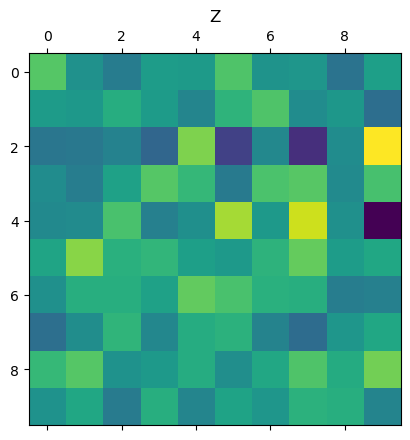

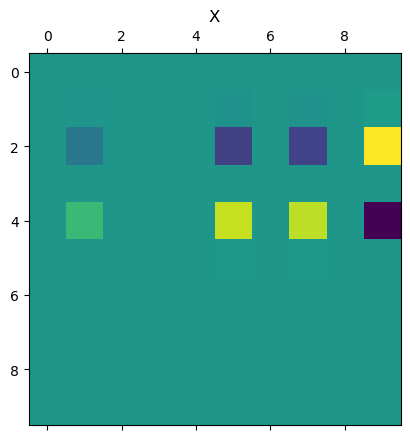

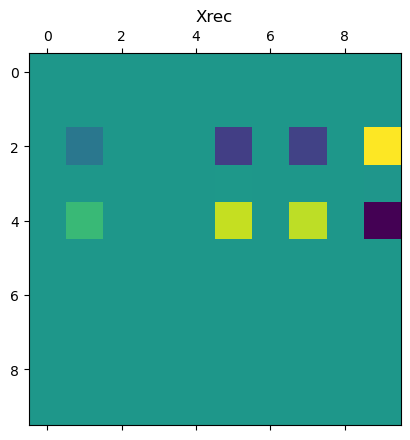

PyObject Text(0.5, 1.0637694145758663, 'Xrec')

In [17]:
# Test
m = 100
k = 4
n = 10
X, S1, S2, As, ys = random_instance(k,m,n) ;
Z = non_convex_method(k,As,ys;print_info=true,true_sol=(X,S1,S2))
@printf("Support recovery error: %d\n",support_recovery_error(X,S1,S2,Z))
@printf("Relative l2 norm error: %.2f\n",norm(Z-X)/norm(X))
PyPlot.matshow(Z)
PyPlot.title("Xrec")

e) A simple possible improvement is to estimate sets $S_1,S_2$ with higher cardinality than $k$. This way, chances to "miss" a non-zero entry are smaller. This improves over the basic strategy. However, the algorithm still works significantly worse than the convex relaxation. A more refined strategy would be a greedy approach, where entries in $S_1,S_2$ are added progressively. However, this requires a significant implementation effort.

In [18]:
function non_convex_method_improved(k,As,ys;print_info=false,true_sol=[],nb_its=1000)
    # true_sol, if non-empty, should be (X,S1,S2)
    m = length(ys)
    n = size(As[1])[1]
    Z = sum([ys[i] * As[i] for i=1:m]) / m
    S1, S2 = approx_support(Z,min(n,floor(Int64,sqrt(0.8*m))))
    if print_info
        PyPlot.matshow(Z)
        PyPlot.title("Z")
        PyPlot.matshow(true_sol[1])
        PyPlot.title("X")
        @printf("S1, S2 =\n")
        println(sort(S1))
        println(sort(S2))
        @printf("True S1, S2 =\n")
        println(sort(true_sol[2]))
        println(sort(true_sol[3]))
    end
    return approx_X_from_support(S1,S2,As,ys;print_info=print_info,nb_its=nb_its)
end

non_convex_method_improved (generic function with 1 method)

S1, S2 =
[2, 4, 5, 6, 7, 8, 9, 10]
[1, 4, 5, 6, 7, 8, 9, 10]
True S1, S2 =
[2, 5, 8, 10]
[4, 6, 7, 10]
Final objective: 0.00
Final gradient norm: 8.08e-02
Support recovery error: 0
Relative l2 norm error: 0.00


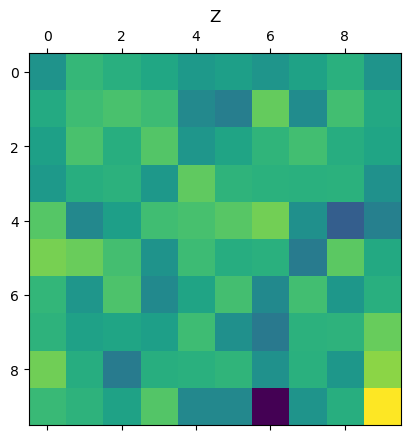

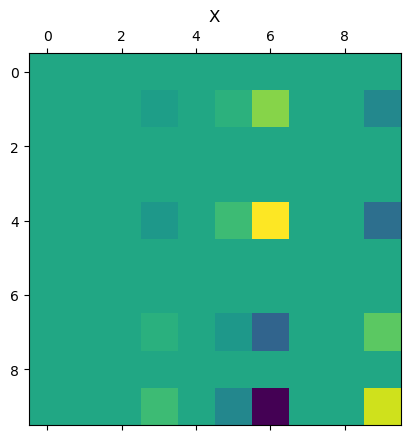

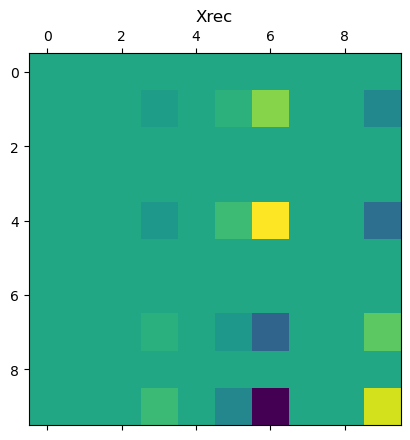

In [19]:
# Test of improved strategy
m = 80
k = 4
n = 10
X, S1, S2, As, ys = random_instance(k,m,n) ;
Z = non_convex_method_improved(k,As,ys;print_info=true,true_sol=(X,S1,S2),nb_its=100)
@printf("Support recovery error: %d\n",support_recovery_error(X,S1,S2,Z))
@printf("Relative l2 norm error: %.2f\n",norm(Z-X)/norm(X))
PyPlot.matshow(Z) ;
PyPlot.title("Xrec") ;